# Instruções Gerais

*   A atividade é **individual**. Cópias e plágios não serão tolerados
*   Data de entrega: **25/11/2021, até as 23:59h**

  * Apenas pelo **Classroom**
  * Façam uma cópia do notebook, e trabalhem nela para a entrega até o prazo definido
  * **Atentem para todos os pontos de `# TODO:`**, pois estes são os pontos de implementação
* Sobre política de atrasos: 
  * cada aluno terá a **tolerância de 2 dias de atraso, considerado todos os exercícios** propostos. 
  * A partir do terceiro dia, 60% da nota obtida será computada. 
  * Do quarto dia em diante, não será atribuída nota alguma.



# **Resolvendo o problema do lago congelado**

Imagine que existe um lago congelado entre sua casa e a universidade, a única forma de chegar a universidade é passando por esse lago.

Tranquilo essa tarefa? Ops! Temos um pequeno problema nesse lago, temos alguns buracos, então você tem que ter cuidado para não cair neles enquanto tenta chegar a sua universidade.


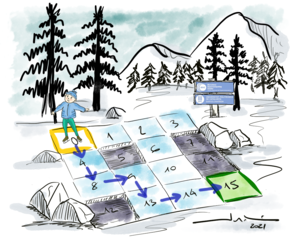

Vamos transformar a imagem anterior em uma matriz:

---



```
[[ S  F  F  F]
 [ F  H  F  H]
 [ F  F  F  H]
 [ H  F  F  G]]
```
E agora vamos definir algumas coisas:



*   $S$ é a sua posição inicial;
*   $F$ é uma parte do lago que está congelado e você pode andar;
*   $H$ é um buraco, então uma parte que você não pode andar;
*   $G$ é o seu objetivo, ou seja, a sua universidade.

Você agora tem informações de como é a distribuição dos buracos no lago, mas você esta com preguiça de pensar em como chegar a sua universidade e decidiu dar essa tarefa para o seu agente resolver e lhe dizer o melhor caminho.

Portanto, a tarefa do seu agente é achar o caminho ótimo para chegar à universidade a partir de $S$ e chegando em $G$, sem cair em nenhum buraco $H$. Como podemos fazer com que o agente chegue nessa solução? Você pode dar ao agente +1 como recompensa se ele chegar no objetivo e 0 em outros casos, assim o agente pode agora descobrir o caminho ótimo. 


Agora que temos uma breve descrição do ambiente, nesse notebook nosso objetivo é resolver esse problema utilizando programação dinâmica e depois utilizando o algoritmo Q-learning, e então podemos no final realizar uma análise dos resultados que obtemos. 


### **`Instalando as dependências no Colab`**

Para realizar essa atividade vamos utilizar o Gym, que é um toolkit para o desenvolvimento de algoritmos de reinforcement learning. 

In [1]:
!pip install gym

### **Importando as depêndencias**

In [2]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt

### **Criando o ambiente e explorando o ambiente**

Na linha seguinte vamos chamar o construtor do ambiente *frozen lake*.

In [3]:
env = gym.make("FrozenLake-v0",is_slippery=False,map_name="4x4")

Você deve estar se perguntando o que essa variável *is_slippery* faz?

* Quando esta variável é igual a False temos um ambiente determinístico, ou seja, quando realizamos uma ação em um certo estado sabemos exatamente o que vai acontecer.

* Quando esta variável é igual a True, que é o padrão do ambiente, temos um ambiente estocástico ,ou seja, quando tomamos uma ação em um certo estado não temos certeza do que vai acontecer.

* Por exemplo, nesse ambiente se temos o lago escorregadio e decidimos ir para a direita por exemplo não temos certeza que a próxima posição será o (x_atual +1,y), pois podemos escorregar e ficar no mesmo lugar ou ir para um lugar aleatório. 

In [4]:
# imprime o espaço de estados e o espaço de ações
print(env.observation_space)
print(env.action_space)

Discrete(16)
Discrete(4)


Nós temos um espaço de observação discreto e com tamanho 16, pois temos um mapa de tamanho 4x4.

O nosso espaço de ações também é discreto e tem tamanho 4, pois temos 4 possíveis ações:
```
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
```



In [5]:
# imprime o número total de estados e ações
print(env.nS)
print(env.nA)

16
4


Por exemplo podemos ver a probabilidade de o agente estar no estado 0 e ir para a direita, utilizando o `env.P`:

In [6]:
env.P[0][2]

[(1.0, 1, 0.0, False)]

A saída que vemos acima representa:

`(prob,next_state, reward, done)`

Onde:

*   `prob` é a probabilidade do próximo estado acontecer a partir do par estado atual e ação.
* `next_state` é o próximo estado.
* `reward` é a recompensa esperada ao chegar nesse próximo estado.
*   `done` é True se o `next_state` é um estado terminal e False caso contrário.

Se você quiser ver como é a Probabilidade desse estado e ação quando temos um ambiente estocástico mude no environment a variável is_slippery para True, e então execute de novo a célula acima.

Uma coisa interessante que você vai observar é que quando temos o `is_slippery = True`, quando realizamos uma ação em um determinado estado não temos mais uma única opção de próximo estado. 





## **Parte 1: Programação Dinâmica**

**Atenção: Antes de realizar as atividades seguintes coloque o is_slippery para False.**

O objetivo dessa primeira parte é construirmos as funções :
* Policy Evaluation
* Policy Interation
* Policy Improvement
* Value interation


### **Policy Evaluation**

No policy evaluation o objetivo é avaliar a política $\pi(s,a)$ estimando a state-value function $v^\pi$

In [7]:
## substitui "s" por "state", "V" por "state_value_arr" e "Vs" por "state_value" para melhor compreensão

def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    state_value_arr = np.zeros(env.nS)
    convergence = False
    while not convergence:
      delta = 0
      for state in range(env.nS):
        state_value = 0

        ## TODO: complete a função
        
        for action, action_prob in enumerate(policy[state]):
          for prob, next_state, reward, done in env.P[state][action]:
            state_value += action_prob * prob * (reward + gamma * state_value_arr[next_state])

        delta = max(delta, np.abs(state_value_arr[state] - state_value))

        ## DONE

        state_value_arr[state] = state_value

      if delta < theta:
          convergence = True
    
    return state_value_arr

No nosso caso de teste, nós vamos avaliar a política aleatória equiprovável  $\pi$, ou seja, nessa política a partir de um estado s a probabilidade de realizar uma das n ações é igual para todas as ações.

onde :

$\pi(a|s) = \frac{1}{|\mathcal{A}(s)|}$ para todo $s\in\mathcal{S}$ e $a\in\mathcal{A}(s)$.

In [8]:
random_policy = np.ones([env.nS, env.nA]) / env.nA

In [9]:
V = policy_evaluation(env, random_policy)

V_np = np.array(V)
V_np = V_np.reshape((4,4))
print(V_np)

[[0.01393977 0.01163091 0.02095297 0.01047648]
 [0.01624865 0.         0.04075153 0.        ]
 [0.03480619 0.08816993 0.14205316 0.        ]
 [0.         0.17582037 0.43929118 0.        ]]



A reposta da célula anterior deve ser a seguinte:
```
[[0.01393977 0.01163091 0.02095297 0.01047648]
 [0.01624865 0.         0.04075153 0.        ]
 [0.03480619 0.08816993 0.14205316 0.        ]
 [0.         0.17582037 0.43929118 0.        ]]

```



Portanto acima temos o State-Value-Function, ou função de valor, que nós diz a recompensa esperada a partir de certa política $\pi$


### **Calculando o Q(s,a)**

Anteriormente descobrimos como computar o state-value function $v_\pi$ a partir de uma política arbritária. 

Nesse momento nosso objetivo é computar o action-value-function $Q^\pi(s,a)$ a partir de um state-value function  $v_\pi$.


In [10]:
## substitui "s" por "state", "V" por "state_value_arr" e "a" por "action" para melhor compreensão

def q_from_v(env, state_value_arr, state, gamma=1):
    q = np.zeros(env.nA)
    for action in range(env.nA):
      for prob, next_state, reward, done in env.P[state][action]:

        # TODO

        q[action] += prob * (reward + gamma * state_value_arr[next_state])

        ## DONE

    return q

In [11]:
Q = np.zeros([env.nS, env.nA])
for s in range(env.nS):
    Q[s] = q_from_v(env, V, s)
print("Action-Value Function:")
print(Q)

Action-Value Function:
[[0.01393977 0.01624865 0.01163091 0.01393977]
 [0.01393977 0.         0.02095297 0.01163091]
 [0.01163091 0.04075153 0.01047648 0.02095297]
 [0.02095297 0.         0.01047648 0.01047648]
 [0.01624865 0.03480619 0.         0.01393977]
 [0.         0.         0.         0.        ]
 [0.         0.14205316 0.         0.02095297]
 [0.         0.         0.         0.        ]
 [0.03480619 0.         0.08816993 0.01624865]
 [0.03480619 0.17582037 0.14205316 0.        ]
 [0.08816993 0.43929118 0.         0.04075153]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.17582037 0.43929118 0.08816993]
 [0.17582037 0.43929118 1.         0.14205316]
 [0.         0.         0.         0.        ]]


### **Policy iteration**

O objetivo aqui é encontrar a política ótima atráves de dois passos:

1.   Avaliando a política atual: Policy Evaluation - Essa função já fizemos acima.
2.   Melhorando essa política : Policy Improvement.



In [12]:
## substitui "s" por "state", "V" por "state_value_arr"

def policy_improvement(env, state_value_arr, gamma=1):
    policy = np.zeros([env.nS, env.nA]) / env.nA
    for state in range(env.nS):
      # TODO

      q = q_from_v(env, state_value_arr, state, gamma)

      ## flatten pra transformar a saida de formato ([[3]]) pra ([3])
      best_action = np.argwhere(q==np.max(q)).flatten()

      ## OneHot pra facilitar a vida
      policy[state] = np.sum([np.eye(env.nA)[x] 
                          for x in best_action], axis=0) / len(best_action)

      ## DONE

    return policy

In [13]:
def policy_iteration(env, gamma=1, theta=1e-8):
    policy = np.ones([env.nS, env.nA]) / env.nA

    ## TODO: 

    help = True
    while help:

        state_values_arr = policy_evaluation(env, policy, gamma, theta)
        policy_melhorada = policy_improvement(env, state_values_arr)

        ## convergencia
        if np.max(abs(policy_evaluation(env, policy) - policy_evaluation(env, policy_melhorada))) < theta * 100:
            help = False;

        policy = policy_melhorada

    ## DONE

    return policy, state_values_arr

In [14]:
policy_pi, V_pi = policy_iteration(env)

print("\nPolítica Ótima (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_pi,"\n")


Política Ótima (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[0.25       0.25       0.25       0.25      ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.25       0.25       0.25       0.25      ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.25       0.25       0.25       0.25      ]
 [0.         0.5        0.         0.5       ]
 [0.25       0.25       0.25       0.25      ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]] 



### **Value iteration**

O value iteration melhora a política após um único passo de policy evaluation, ou seja, ele é mais rápido que o policy interation.

Como funciona o value iteration:

1. Na função "value iteration" inicializamo com um valor aleátorio para a função de valor o nosso V(s).
2. Depois vamos computar a função Q para todos pares de estado e ação de Q(s,a).
3. Depois vamos atualizar nossa função de vaalor V(s) com o valor máximo de Q(s,a)
4. Nós repetimos os passos 1,2 e 3 até que a mudanças que fizermos na função de valor seja muito pequena. 

Depois que obtemos a função de valor ótima podemos estimar a politica a partir da função de **policy improvement.** 

In [15]:
def value_iteration(env, gamma=1, theta=1e-8):
    state_values_arr = np.zeros(env.nS)
    
    ## TODO: complete the function

    help = True
    while help:
        delta = 0
        for state in range(env.nS):
          value = state_values_arr[state]
          state_values_arr[state] = max(q_from_v(env, state_values_arr, state, gamma))
          delta = max(
              delta, abs(state_values_arr[state] - value))

        ## convergencia
        if delta < theta:
          help = False


    policy = policy_improvement(env, state_values_arr, gamma)

    ## DONE

    return policy, state_values_arr

In [16]:
policy_vi, V_vi = value_iteration(env)


print("\nPolítica Ótima (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_vi,"\n")



Política Ótima (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[0.25       0.25       0.25       0.25      ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.25       0.25       0.25       0.25      ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.25       0.25       0.25       0.25      ]
 [0.         0.5        0.         0.5       ]
 [0.25       0.25       0.25       0.25      ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]] 



In [17]:
print(V_vi,"\n")

[1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.] 



## **Parte 2: Q-learning**

In [18]:
env = gym.make("FrozenLake-v0")

In [19]:
# Cria nossa tabela Q com o tamanho : número de estados x número de ações (16x4)
qtable = np.zeros((env.nS, env.nA))
print(qtable)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [20]:
total_episodes = 20000       # Total de episódios
learning_rate = 0.7          # Taxa de aprendizado
max_steps = 99               # Número máximo de passos por episodio
gamma = 0.95                 # Taxa de desconto

# Parâmetros de exploração
epsilon = 1.0                 # Taxa de exploração
max_epsilon = 1.0             # Probabilidade de exploração no ínicio
min_epsilon = 0.01            # Mínima taxa de exploração
decay_rate = 0.005            # Taxa exponecial de decaimento para a probabilidade de exploração

In [21]:
# Lista de recompensas 
import copy

rewards = []
q_over_time = []
size = 0
for episode in range(total_episodes):
    # Reset do ambiente
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
      # TODO : Q- LEARNING

      # escolher entre eplorar ou não
      if random.uniform(0, 1) > epsilon:
        action = np.argmax(qtable[state,:])
      else:
        action = env.action_space.sample()
      
      new_state, reward, done, info = env.step(action)

      ## bellman ---> https://wikimedia.org/api/rest_v1/media/math/render/svg/678cb558a9d59c33ef4810c9618baf34a9577686
      qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
      total_rewards += reward
      state = new_state
      q_over_time.append(copy.copy(qtable))
      size += 1

      if done == True:
        break

      ## DONE
        
    # Redução do epsilon (porque precisamos cada vez menos exploração)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)
    

print ("Recompensa ao longo tempo" +  str(sum(rewards)/total_episodes))
print(qtable)

Recompensa ao longo tempo0.49715
[[8.03974090e-02 6.84527739e-02 6.12487174e-02 6.75847196e-02]
 [7.99366168e-03 2.11889170e-02 1.84356901e-03 3.68615195e-02]
 [4.90354940e-02 1.16471396e-02 1.31086513e-02 1.15928613e-02]
 [1.01654887e-02 3.47720002e-03 2.79904649e-03 3.12449160e-02]
 [1.10512820e-01 6.09338957e-02 1.42077698e-02 8.78083120e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.56178745e-02 3.87202906e-03 1.81377503e-03 8.73525252e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.28173594e-02 1.89860545e-02 3.38091098e-02 1.60844164e-01]
 [4.04482999e-02 3.56380576e-01 1.53634776e-02 5.72754419e-03]
 [3.74888092e-01 3.02137210e-02 1.55674039e-02 5.24384987e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.04936066e-02 1.22837976e-01 2.96899175e-01 5.67786825e-02]
 [1.92852623e-01 7.81785098e-01 2.39477012e-01 2.38971939e-01]
 [0.00000000e+00 0.000

In [22]:
env.reset()

qtable_array = []

for episode in range(5):
    state = env.reset()
    step = 0
    done = False
    print("****************************************************")
    print("EPISODIO:", episode)

    for step in range(max_steps):

        action = np.argmax(qtable[state,:])

        new_state, reward, done, info = env.step(action)

        
        if done:

            qtable_array.append(qtable)

            env.render()
            if new_state == 15:
                print("Chegamos ao nosso objetivo!")
            else:
                print("Caímos em um buraco")
            
            print("Número de passos", step)
            
            break
        state = new_state
        ##print(state)
env.close()

****************************************************
EPISODIO: 0
  (Down)
SFFF
FHFH
FFFH
HFFG
Chegamos ao nosso objetivo!
Número de passos 32
****************************************************
EPISODIO: 1
  (Down)
SFFF
FHFH
FFFH
HFFG
Chegamos ao nosso objetivo!
Número de passos 21
****************************************************
EPISODIO: 2
  (Down)
SFFF
FHFH
FFFH
HFFG
Chegamos ao nosso objetivo!
Número de passos 17
****************************************************
EPISODIO: 3
  (Down)
SFFF
FHFH
FFFH
HFFG
Chegamos ao nosso objetivo!
Número de passos 24
****************************************************
EPISODIO: 4
  (Left)
SFFF
FHFH
FFFH
HFFG
Caímos em um buraco
Número de passos 46


## **Parte 3: Comparação entre o Resultado da Programação Dinâmica e o Q-learning**

Agora que você já sabe definir a política ótima utilizando a Programação dinâmica e o q-learning, plote usando o matplotlib o Mean Squared Error entre o state-value function definida pela programação dinâmica e o state-value function a cada episodio do q-learning, sabendo que isso muda de acordo com a política escolhida.

In [23]:
from sklearn.metrics import mean_squared_error

true_value_of_y = policy_vi

list = []

for x in range(size):

  predicted_value_of_y = q_over_time[x]

  mean_squared_error(true_value_of_y,predicted_value_of_y)
  list.append(mean_squared_error(true_value_of_y,predicted_value_of_y))
  #print(mean_squared_error(true_value_of_y,predicted_value_of_y))

In [24]:
# TODO : o state-value function definida pela programação dinâmica e o state-value function a cada episodio do q-learning
mse = list

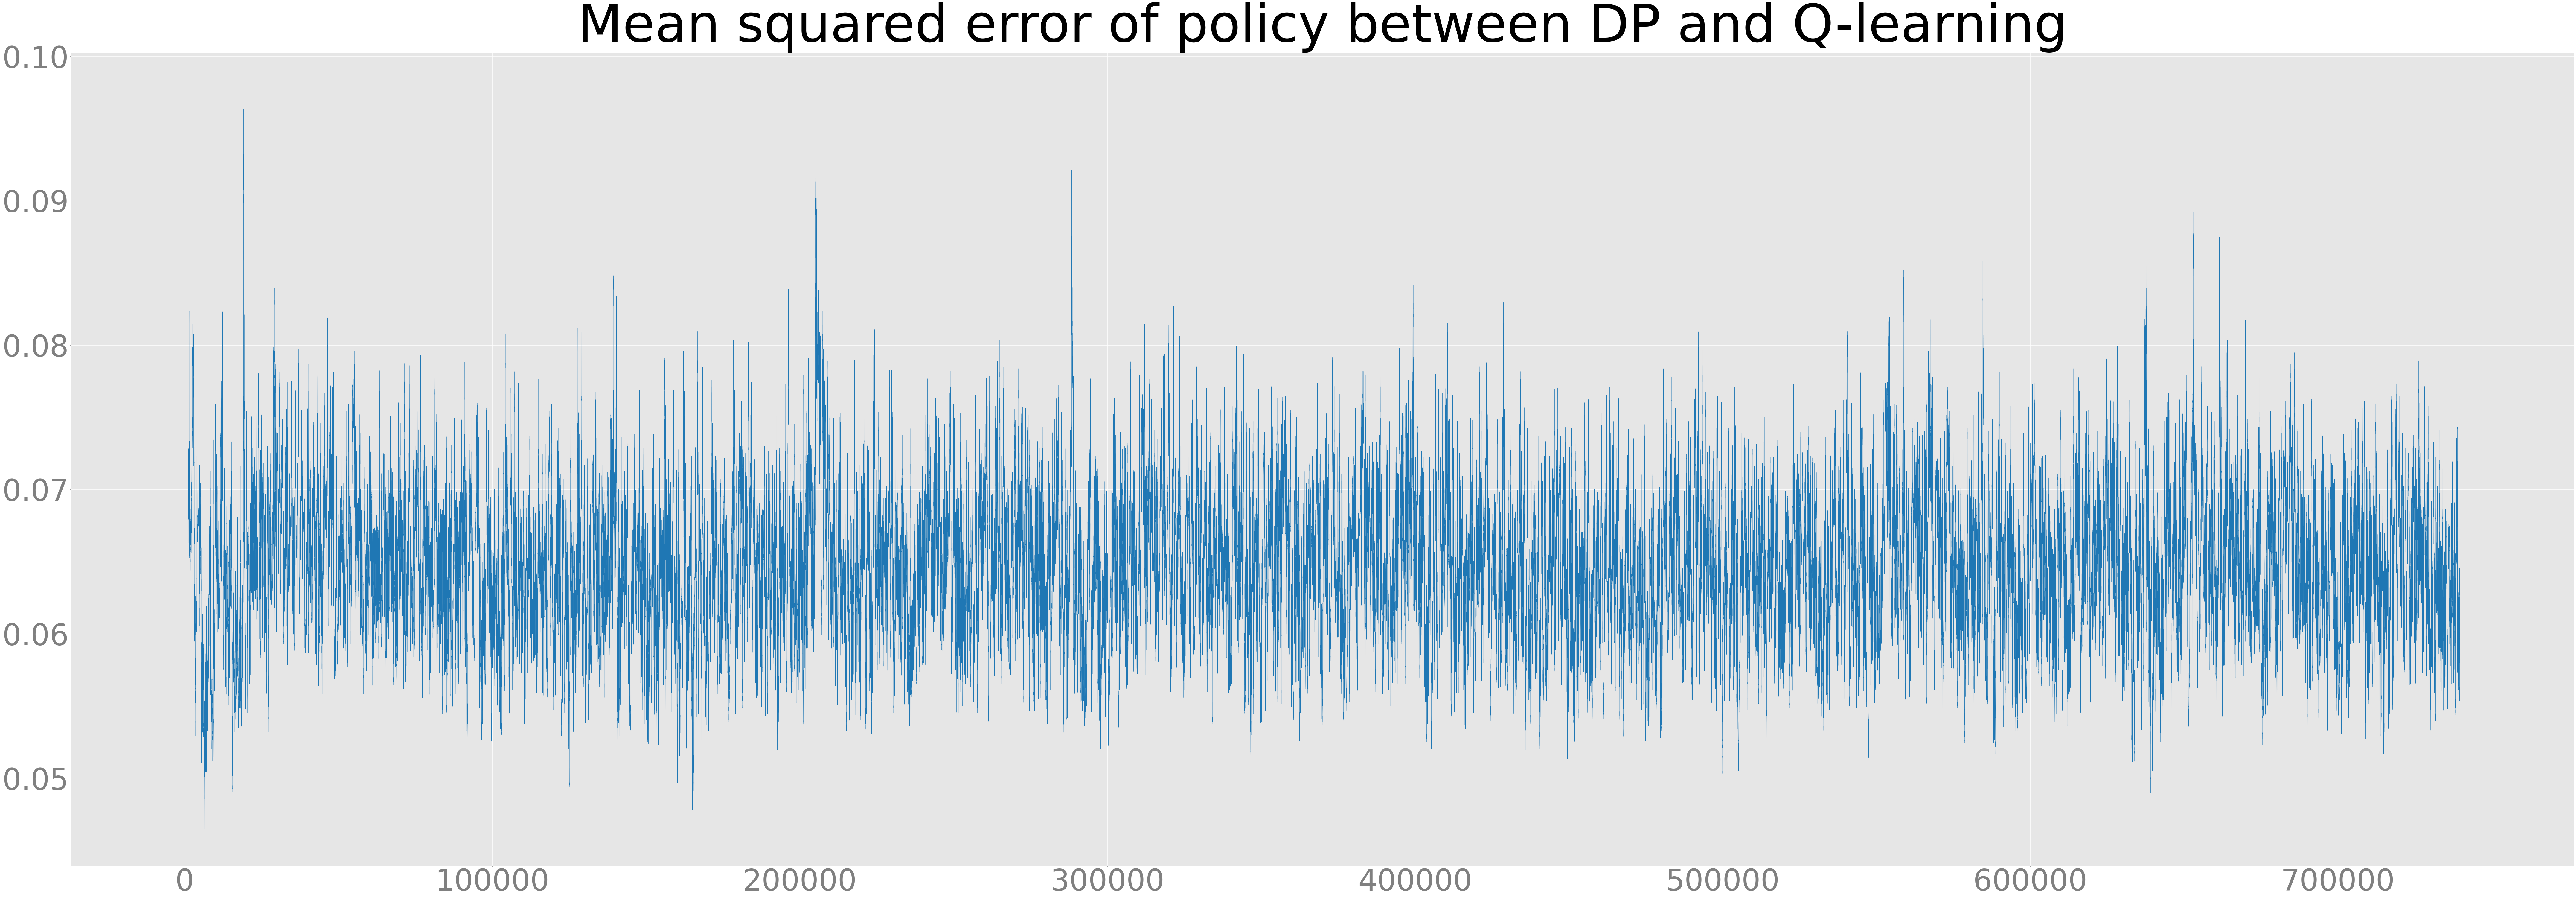

In [25]:
    plt.figure(figsize=(150,50))
    ax = plt.axes(facecolor='#E6E6E6')
    ax.set_axisbelow(True)

    plt.grid(color='w', linestyle='solid')

    for spine in ax.spines.values():
        spine.set_visible(False)
        
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()

    ax.tick_params(colors='gray', direction='out', labelsize=100)
    for tick in ax.get_xticklabels():
        tick.set_color('gray')
    for tick in ax.get_yticklabels():
        tick.set_color('gray')
    plt.title("Mean squared error of policy between DP and Q-learning", fontsize=175)
    plt.plot(range(len(mse)),mse,label="Agent Q-learning",linewidth=1)

# **Curiosidade**

Se você achar interessante você pode repetir todas as etapas anteriores com o `is_slippery = True` e ver se aconteceu algo diferente.

## **Referências**


> Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.



> Ravichandiran, Sudharsan. Hands-on reinforcement learning with Python: master reinforcement and deep reinforcement learning using OpenAI gym and tensorFlow. Packt Publishing Ltd, 2018.



> Lapan, Maxim. Deep reinforcement learning hands-on. Packt publishing, 2020.


> Udacity : Deep Reinforcement Learning Nanodegree program

> Thomas Simonini : Deep RL Course

